<a href="https://colab.research.google.com/github/stwind/notebooks/blob/master/rbm-tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

tfk = tf.keras
tfkl = tf.keras.layers

rc = {
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 6),
    'grid.linewidth': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 14,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 14,
}
sns.set('notebook', 'whitegrid', rc=rc)

## Data

In [2]:
data = tfds.load('mnist', split='train')

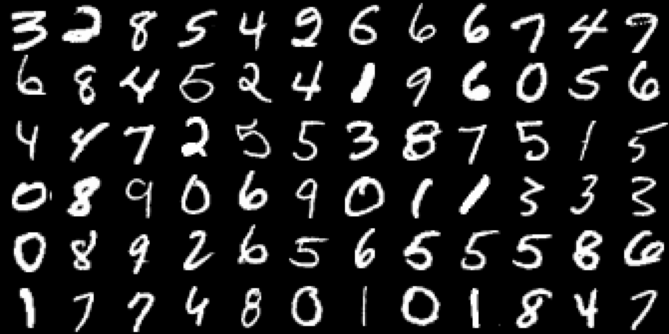

In [3]:
size, dim = 28, np.array([6,12])

fig, ax = plt.subplots(figsize=(6,4))

img = np.zeros(dim * size, dtype='uint8')

for i, d in data.shuffle(1000).take(dim.prod()).enumerate().as_numpy_iterator():
    ix, iy = divmod(i, dim[1])
    img[ix*size:(ix+1)*size, iy*size:(iy+1)*size] = d['image'].squeeze()

ax.imshow(img, cmap="gray")
ax.set_axis_off()
with plt.rc_context({"savefig.pad_inches": 0}):
    plt.show()

In [4]:
def preprocess(d):
    return tf.reshape(tf.cast(d['image'], tf.float32) / 255.0, (-1,784))

train_ds = data.map(preprocess)

## Model

In [5]:
def bernoulli(p):
    return tf.nn.relu(tf.math.sign(p - tf.random.uniform(tf.shape(p))))

class RBMLayer(tfkl.Layer):
    def __init__(self, n_vis, n_hid, k=1, name="rbm"):
        super(RBMLayer, self).__init__(name="rbm")
        self.W = self.add_weight("weights", [n_vis, n_hid], initializer="GlorotNormal")
        self.b = self.add_weight("visible_bias", [1, n_vis], initializer="zeros")
        self.c = self.add_weight("hidden_bias", [1, n_hid], initializer="zeros")
        self.k = k
        
    def h_given_v(self, v):
        return tf.math.sigmoid(tf.matmul(v, self.W) + self.c)

    def v_given_h(self, h):
        return tf.math.sigmoid(tf.matmul(h, self.W, transpose_b=True) + self.b)
    
    def free_energy(self, v):
        first = tf.matmul(v, self.b, transpose_b=True)
        second = tf.reduce_sum(tf.math.softplus(tf.matmul(v, self.W) + self.c), axis=1)
        return tf.reduce_mean(- first - second)

    def sample(self, v, k=1):
        h = bernoulli(self.h_given_v(v))
        
        neg_v_p = self.v_given_h(h)
        neg_v = bernoulli(neg_v_p)
        neg_h = bernoulli(self.h_given_v(neg_v))
        
        for _ in range(k-1):
            neg_v_p = self.v_given_h(neg_h)
            neg_v = bernoulli(neg_v_p)
            neg_h = bernoulli(self.h_given_v(neg_v))

        return neg_v_p

    def call(self, v):
        h = bernoulli(self.h_given_v(v))
        neg_v = bernoulli(self.v_given_h(h))
        neg_h = bernoulli(self.h_given_v(neg_v))
        for _ in range(self.k-1):
            neg_v = bernoulli(self.v_given_h(neg_h))
            neg_h = bernoulli(self.h_given_v(neg_v))
            
        self.add_loss(self.free_energy(v) - self.free_energy(neg_v))
        
        return neg_v

In [7]:
inp = tfk.Input(shape=(784,), name="input")
out = RBMLayer(784, 128)(inp)
model = tfk.Model(inp, out,name="rbm")

model.summary()

Model: "rbm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
rbm (RBMLayer)               (None, 784)               101264    
Total params: 101,264
Trainable params: 101,264
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer="adam")
model.fit(train_ds, batch_size=64, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 44s 738us/step - loss: -7.6227
Epoch 2/10
60000/60000 [==============================] - 45s 758us/step - loss: -2.1766
Epoch 3/10
60000/60000 [==============================] - 44s 730us/step - loss: -0.2595
Epoch 4/10
60000/60000 [==============================] - 44s 739us/step - loss: 0.5203
Epoch 5/10
60000/60000 [==============================] - 44s 735us/step - loss: 0.8060
Epoch 6/10
60000/60000 [==============================] - 44s 733us/step - loss: 0.9450
Epoch 7/10
60000/60000 [==============================] - 39s 657us/step - loss: 1.0329
Epoch 8/10
60000/60000 [==============================] - 38s 632us/step - loss: 1.1017
Epoch 9/10
60000/60000 [==============================] - 37s 623us/step - loss: 1.1667
Epoch 10/10
60000/60000 [==============================] - 38s 627us/step - loss: 1.1751


In [11]:
v = next(train_ds.batch(64).take(1).as_numpy_iterator()).reshape(-1,784)

v_gibbs = model.layers[1].sample(v)

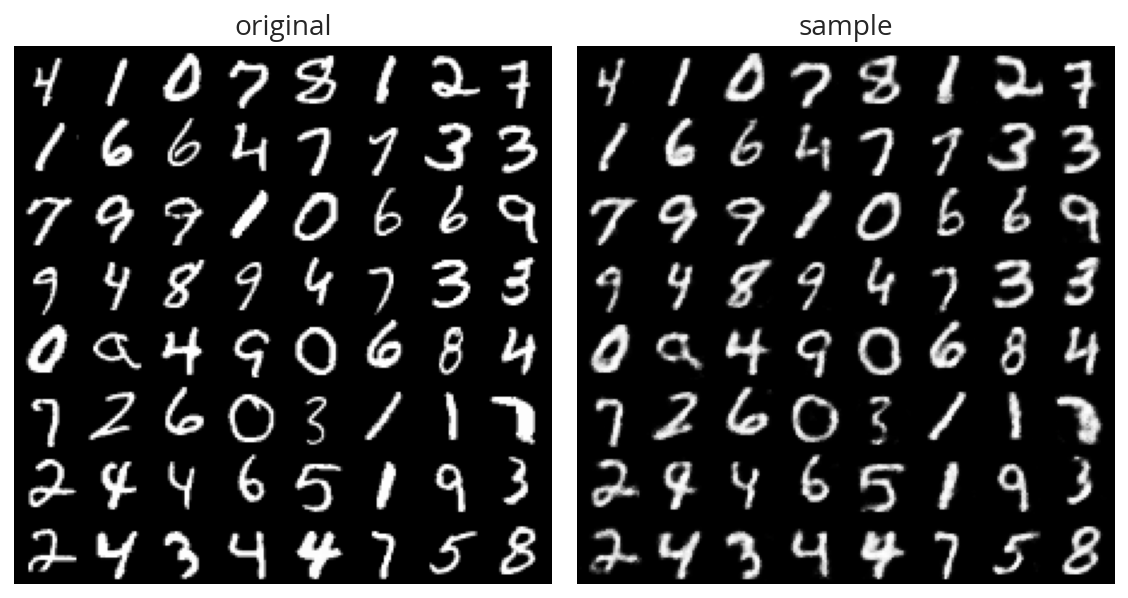

In [12]:
size, dim = 28, np.array([8,8])

fig, ax = plt.subplots(1, 2, figsize=(8,5))

img = np.zeros(dim * size, dtype=np.float32)
for i in range(dim.prod()):
    ix, iy = divmod(i, dim[1])
    img[ix*size:(ix+1)*size, iy*size:(iy+1)*size] = v[i].reshape((28,28))
    ax[0].imshow(img, cmap="gray")
    ax[0].set_axis_off()
    ax[0].set(title="original")
    
img = np.zeros(dim * size, dtype=np.float32)
for i in range(dim.prod()):
    ix, iy = divmod(i, dim[1])
    img[ix*size:(ix+1)*size, iy*size:(iy+1)*size] = v_gibbs[i].numpy().reshape((28,28))
    ax[1].imshow(img, cmap="gray")
    ax[1].set_axis_off()
    ax[1].set(title="sample")

plt.tight_layout()
plt.show()

In [13]:
model.save("rbm")

INFO:tensorflow:Assets written to: rbm/assets


INFO:tensorflow:Assets written to: rbm/assets
